# Bank transaction classifier

## Data exploring

In [1]:
# import 'em all
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
#from scipy.stats import norm
#from sklearn.preprocessing import StandardScaler
#from scipy import stats
#import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# go get the data
df = pd.read_csv("../input/creditcard.csv")

In [3]:
# let's see what's inside
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


All V variables are normalized, we need to decide how to manage Amount and Time.

I will start with the latter one. Time is counted from 0.0 and is measured in seconds.

In [4]:
df.Time.max()/3600

47.997777777777777

Almost 48 hours or 2 whole days. First thing on my mind? Plot frad vs normal transactions depending on second, minute, hour..

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


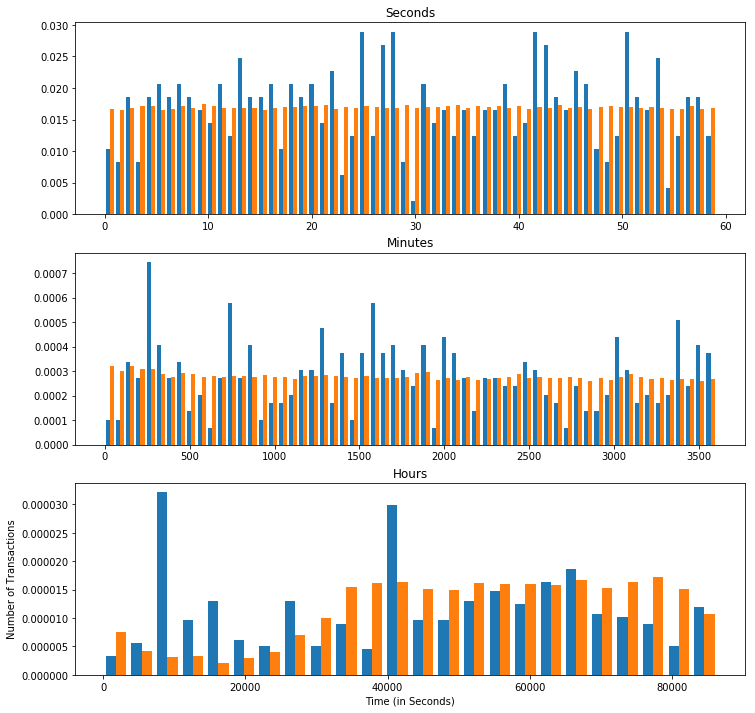

In [5]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(12,12))

ax1.hist((df.Time[df.Class == 1]%60, df.Time[df.Class == 0]%60), bins = 60, normed=True, label=("Fraud","Normal"))
ax1.set_title('Seconds')

ax2.hist((df.Time[df.Class == 1]%3600,  df.Time[df.Class == 0]%3600), bins = 60, normed=True, label=("Fraud","Normal"))
ax2.set_title('Minutes')

ax3.hist((df.Time[df.Class == 1]%(3600*24),  df.Time[df.Class == 0]%(3600*24)), bins = 24, normed=True, label=("Fraud","Normal"))
ax3.set_title('Hours')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

And we got.. nothing. Plan B: Amount against Time. 

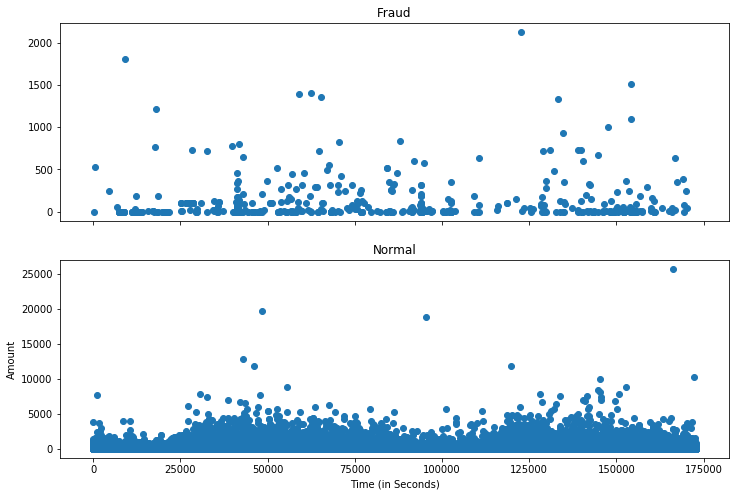

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))

ax1.scatter(df.Time[df.Class == 1], df.Amount[df.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df.Time[df.Class == 0], df.Amount[df.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

At this point we cannot tell anything specyfic about the data. The time seems to be useless, so we'll get rid of it. 

In [7]:
df = df.drop(['Time'], axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


All features but Amount have been previously transformed with PCA.

We can assume that they are all lineary independent. But.. can we?

In [8]:
#normalize Amount 
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape((-1, 1)))
df = df.drop(['Amount'], axis=1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


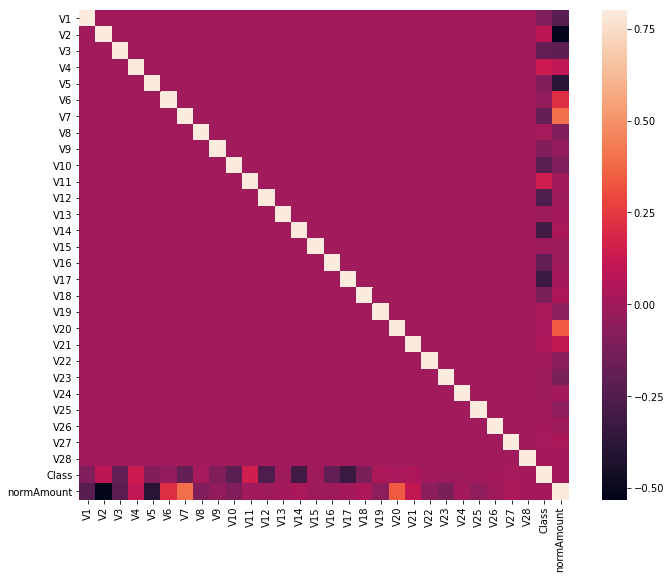

In [9]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [10]:
corrmat.nlargest(5, 'Class')['Class']

Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
Name: Class, dtype: float64

Not a single suspicious correlation for now. Too suspicius to be left unexamined.


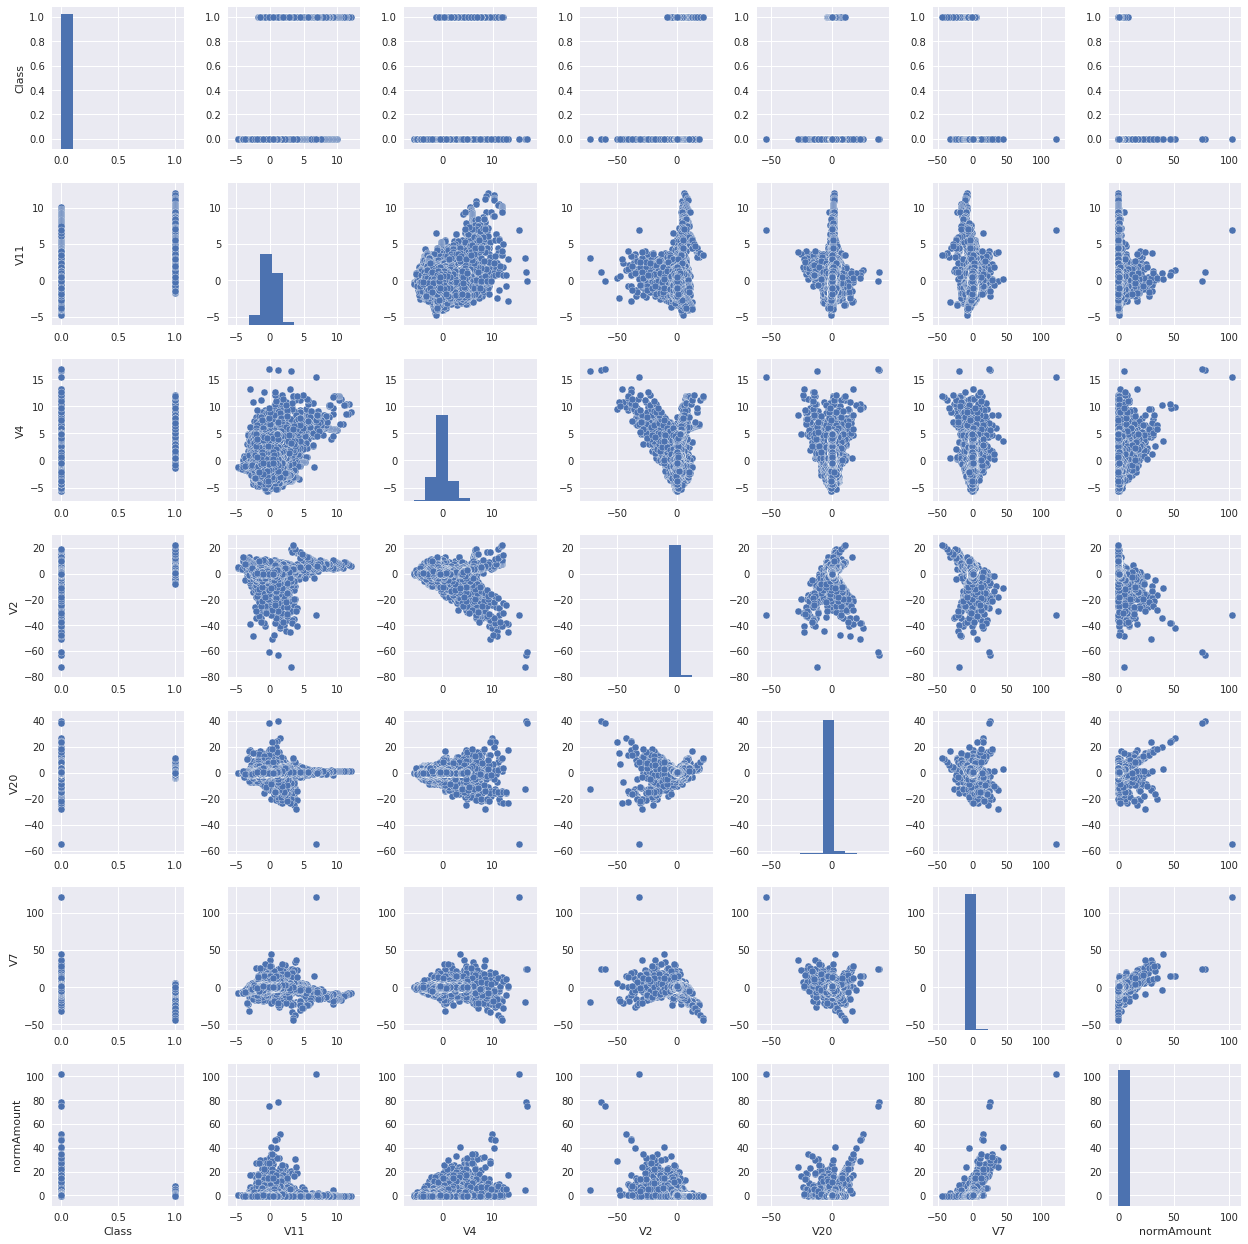

In [11]:
#scatterplot
sns.set()
cols = ['Class', 'V11', 'V4', 'V2', 'V20', 'V7', 'normAmount']
sns.pairplot(df[cols], size = 2.5)
plt.show();

It's hard to find anything usefull here.

Next step: checking the missing data

In [12]:
#every soul on board?
df.isnull().sum().sum()

0

Finally a perfectly filled dataset!

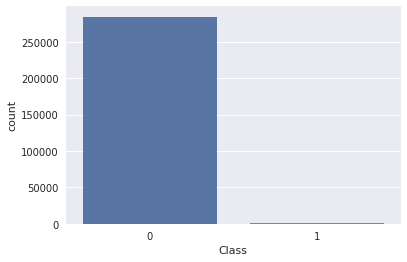

In [13]:
sns.countplot("Class",data=df)

In [14]:
class Perceptron(object):
    """Perceptron classifier.
    
    Parameters    
    -----------    
    eta : float        
        Learning rate (between 0.0 and 1.0)    
    n_iter : int        
        Passes over the training dataset.
    
     Attributes    
     ----------    
     w_ : 1d-array        
         Weights after fitting.    
    errors_ : list        
        Number of misclassifications in every epoch.
    
    """    
    def __init__(self, eta=0.01, n_iter=10):        
        self.eta = eta        
        self.n_iter = n_iter
    def fit(self, X, y):        
        """Fit training data.
        
        Parameters        
        ---------        
        X : {array-like}, shape = [n_samples, n_features]            
            Training vectors, where n_samples is the number of samples and 
            n_features is the number of features.
        y : array-like, shape = [n_samples]            
            Target values.
        
        Returns        
        ------        
        self : object
        
        """        
        self.w_ = np.zeros(1 + X.shape[1])        
        self.errors_ = []
        
        for _ in range(self.n_iter):            
            errors = 0            
            for xi, target in zip(X, y):                
                update = self.eta * (target - self.predict(xi))                
                self.w_[1:] += update * xi                
                self.w_[0] += update                
                errors += int(update != 0.0)            
            self.errors_.append(errors)        
        return self
    
    def net_input(self, X):        
        """Calculate net input"""        
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):        
        """Return class label after unit step"""        
        return np.where(self.net_input(X) >= 0.0, 1, -1)